# Techniques Showroom

> This notebook is based on the medium post from [here](https://towardsdatascience.com/exploring-image-processing-techniques-opencv-4860006a243).

We will go through fundamental image processing techniques with OpenCV in this notebooks. 


Before starting, make sure you have done below:
- Install the dependencies via `pip install -r requirements.txt`. (Virtual environment is recommended)
- Prepare an interesting image for following experiments!

Let's go!

----

## Preparation

First import the necessary packages, and define the path to your testing images.

Note that image read via opencv is in BGR format, but matplotlib is expecting image in BGR. We will need a helper function to easily display the image in all the following codes.

In addition, `plt.imshow` requires extra parameter if the input image is in gray-scale. Refer to [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) for more information.

That's why we are importing a helper function `plt_show` here.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from utils.helper import plt_show

test_img = cv.imread("./tmp/test1.jpeg")
if test_img is None:
    print('Image was not read successfully')

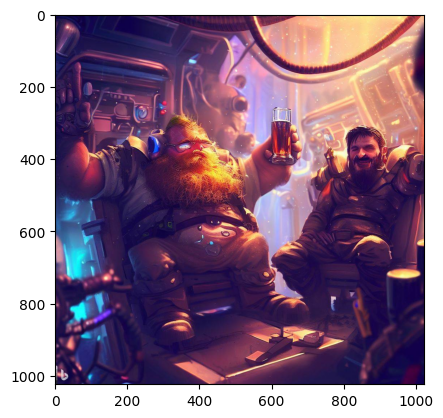

In [31]:
# Display the image
plt_show(test_img)

From OpenCV: Note that the default color format in OpenCV is often referred to as RGB **but it is actually BGR** (the bytes are reversed). So the first byte in a standard (24-bit) color image will be an 8-bit Blue component, the second byte will be Green, and the third byte will be Red.

The conventional ranges for R, G, and B channel values are:

- 0 to 255 for CV_8U images
- 0 to 65535 for CV_16U images
- 0 to 1 for CV_32F images

In [28]:
print("Image dimension: ", test_img.shape)
print("Image type: ", test_img.dtype)

Image dimension:  (1024, 1024, 3)
Image type:  uint8


------
## Color space conversion

It is a common technique to convert RGB into Gray style via `cvtColor`. [Here](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#gga4e0972be5de079fed4e3a10e24ef5ef0a8199112edf021b1586c75ca20a46ecd1) is a full list of available conversion type.


(1024, 1024)


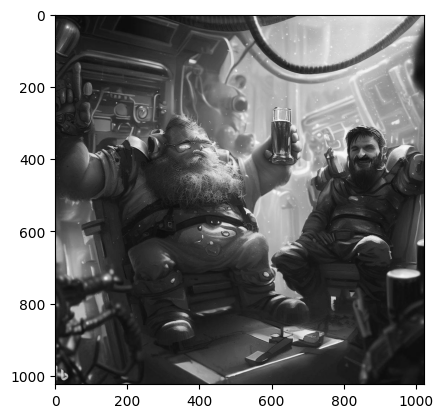

In [29]:

# Grayscale version of the input:
gray = cv.cvtColor(test_img, cv.COLOR_BGR2GRAY)
plt_show(gray, is_gray=True)
print(gray.shape)

We can even split the original BGR image into separated channels by `cv.split`:

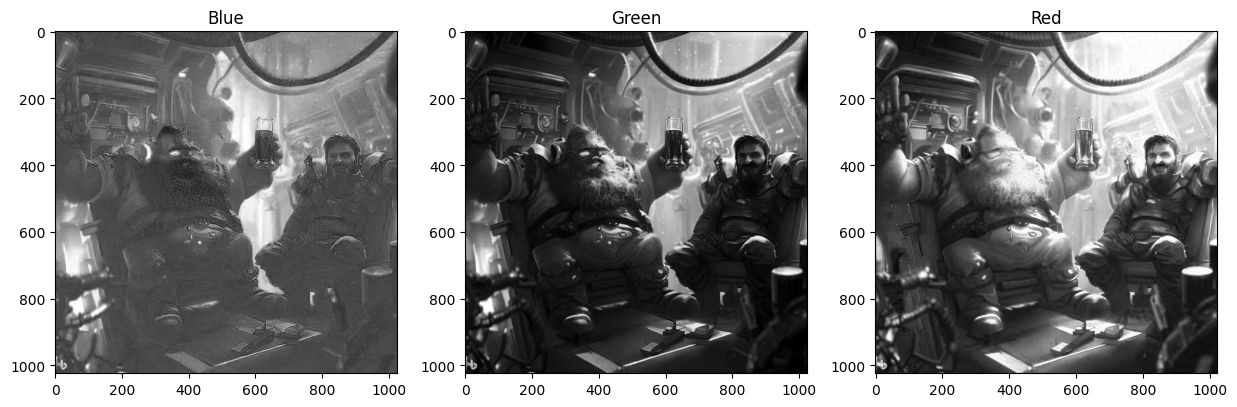

In [34]:
blue, green, red = cv.split(test_img)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].set_title("Blue")
plt_show(blue, axs_obj=axs[0])
axs[1].set_title("Green")
plt_show(green, axs_obj=axs[1])
axs[2].set_title("Red")
plt_show(red, axs_obj=axs[2])


Images above are not accurately being displayed by their color because each channel will be treated as a gray scale individually. We can convert them back to 3-d array and `mixChannels` comes in handy.

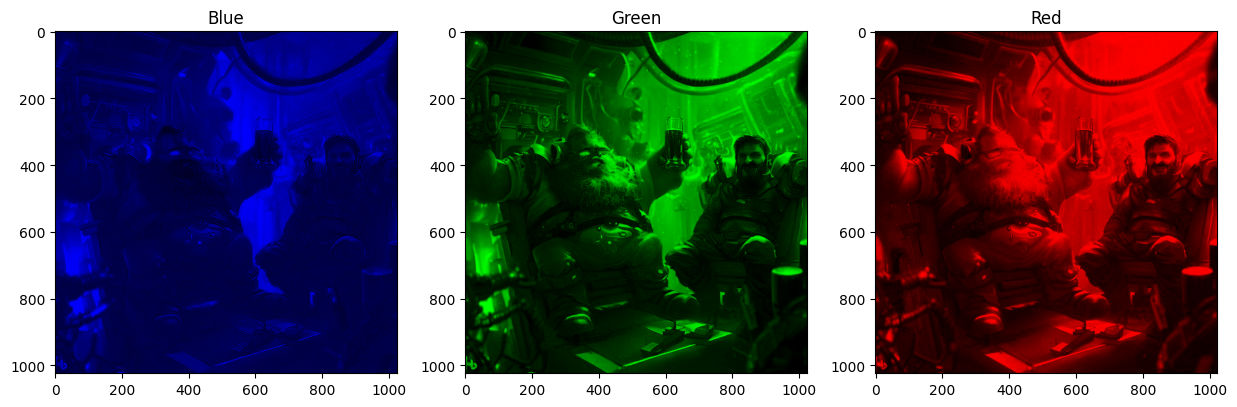

In [35]:
# We create a dummy 3D array
blue_channel = np.zeros(test_img.shape, test_img.dtype)
green_channel = np.zeros(test_img.shape, test_img.dtype)
red_channel = np.zeros(test_img.shape, test_img.dtype)

# We match each color channel to a 3D dimension:
    # Blue Rendering : [blue; 0; 0]
    # Green Rendering: [0; green; 0]
    # Red Rendering: [0; 0; red]
cv.mixChannels([blue, green, red], [blue_channel], [0,0])
cv.mixChannels([blue, green, red], [green_channel], [1,1])
cv.mixChannels([blue, green, red], [red_channel], [2,2])


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].set_title("Blue")
plt_show(blue_channel, axs_obj=axs[0])
axs[1].set_title("Green")
plt_show(green_channel, axs_obj=axs[1])
axs[2].set_title("Red")
plt_show(red_channel, axs_obj=axs[2])

------

## Contrast adjustment

To simplify the concept, you can think the formula inside convertScaleAbs is like:
- each_pixel * alpha + beta


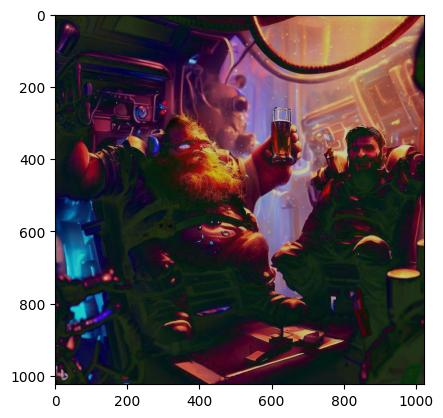

In [45]:

# New dummy image that will contain the adjustments
adjusted_image = np.zeros(test_img.shape, test_img.dtype)

# Defining alpha and beta:
alpha = 1.0   # Contrast Control [1.0-3.0]
beta = -50    # Brightness Control [0-100]

# Scaling and converting the image contrast and brightness
adjusted_image = cv.convertScaleAbs(test_img, alpha=alpha, beta=beta)
plt_show(adjusted_image)

--------

## Histogram Equalization

By displaying the histogram of an image, sometimes we might observe the pixel values are skewed to one side. It could be a problem for certain tasks. That's when we need histogram equalization.

i.e. To correct darkest areas in the image to make it feel more appealing

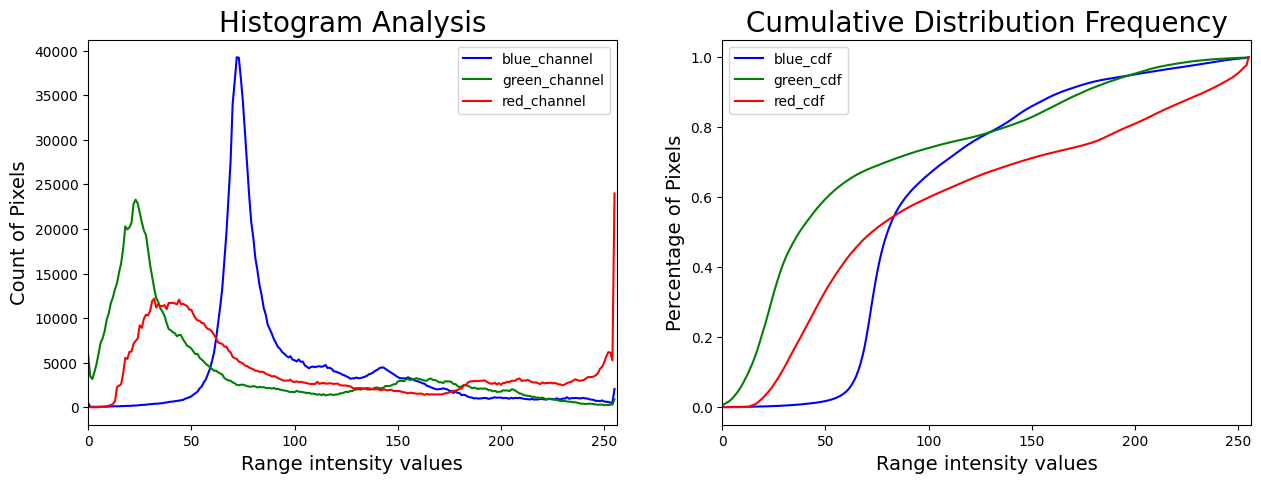

In [60]:
# We will re-use it soon
def hist_analysis(target_img):
    # Plot the pixel intensity distribution
    # setting RGB color list:
    color = ('blue', 'green', 'red')
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Iterating throuhg each channel and plotting the corresponding result:
    # using cv.calcHist() opencv method
    for i,color in enumerate(color):
        histogram = cv.calcHist([target_img], [i], None, [256], [0, 256])
        cdf = histogram.cumsum()
        cdf_percent = cdf / cdf.max()
        axs[0].plot(histogram, color=color, label=color+'_channel')
        axs[0].set_xlim([0,256])
        axs[1].plot(cdf_percent, color=color, label=color+'_cdf')
        axs[1].set_xlim([0,256])

    axs[0].set_title('Histogram Analysis',fontsize=20)
    axs[0].set_xlabel('Range intensity values',fontsize=14)
    axs[0].set_ylabel('Count of Pixels',fontsize=14)
    axs[0].legend()

    axs[1].set_title('Cumulative Distribution Frequency',fontsize=20)
    axs[1].set_xlabel('Range intensity values',fontsize=14)
    axs[1].set_ylabel('Percentage of Pixels',fontsize=14)
    axs[1].legend()
    plt.show()

hist_analysis(test_img)

Depending on the image chosen, you might observe different distribution. There might be some pixels concentrated in a certain range.
Applying the equalization formula helps to stretch the confined region to either histogram boundaries. The values are spread to their maximum to improve image lightning.

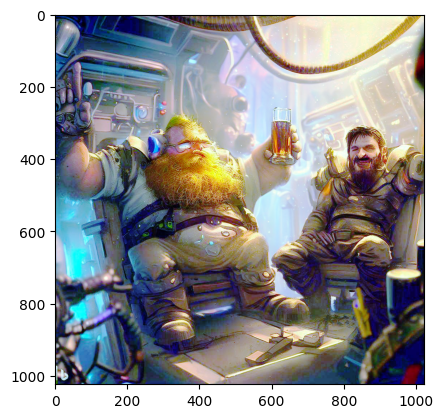

In [59]:
# setting RGB color list:
color = ('blue', 'green', 'red')
split_value = cv.split(test_img)

merged_img = []
# Iterating throuhg each channel
# using cv.calcHist() opencv method
for i,color in enumerate(color):
    histogram = cv.calcHist([test_img], [i], None, [256], [0, 256])
    # cumulative distribution frequency
    cdf = histogram.cumsum()
    # Mask null values 
    cdf_masked = np.ma.masked_equal(cdf, 0)
    # Apply Equalization Formula to all non masked values: (y - ymin)*255 / (ymax - ymin)
    cdf_masked = (cdf_masked - cdf_masked.min())*255 / (cdf_masked.max() - cdf_masked.min())
    # Put back null values
    cdf_final = np.ma.filled(cdf_masked, 0).astype('uint8')
    # Merge all channels:
    merged_img.append(cdf_final[split_value[i]])

# Final output, equalized image obtained from merging the respective channels 
final_equ_img = cv.merge(merged_img)
plt_show(final_equ_img)

And let's check the histogram too. 

We observe a linear tendency growth for intensity values, meaning that pixel intensities are now equally distributed in the image and the regions concentrating high-intensity pics are more likely to disappear.



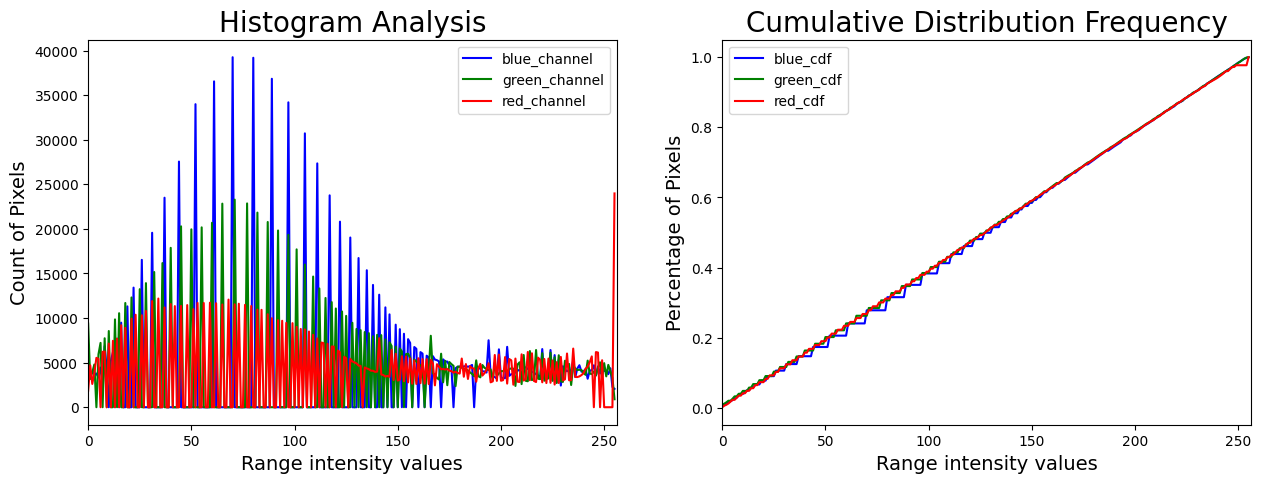

In [61]:
hist_analysis(final_equ_img)

------
## Convolution

## Laplacian derivatives

Laplacian Derivatives - highlights regions of rapid intensity change and it’s widely used as a prior step for edge detection.

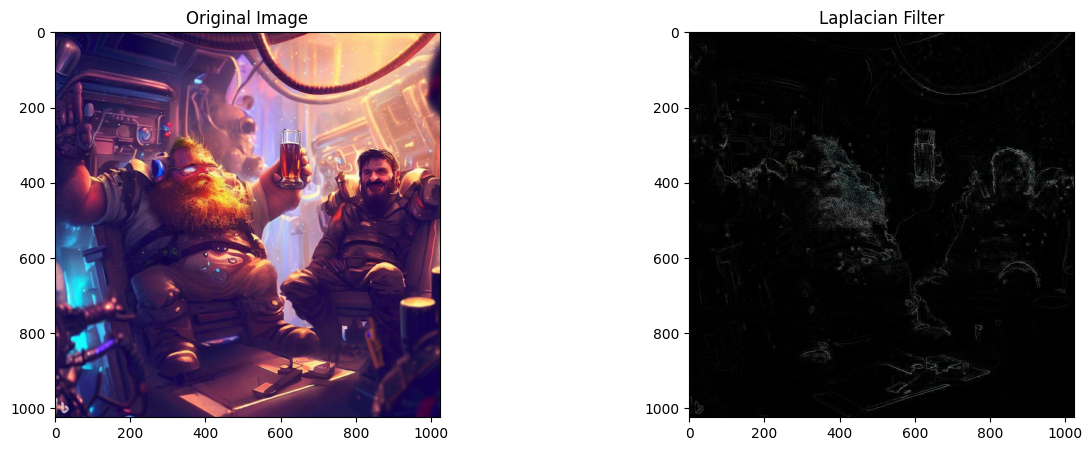

In [62]:
# Applying Laplacian transformation:
# Note: you might need to change the image type if your image is not 8bit
laplacian = cv.Laplacian(test_img, cv.CV_8UC3)

# Display original and transformed images
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_title("Original Image")
plt_show(test_img, axs_obj=axs[0])
axs[1].set_title('Laplacian Filter')
plt_show(laplacian, axs_obj=axs[1])